In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/week-shoptype/week_shoptype.csv
/kaggle/input/week-shoptype/test.csv


In [2]:
!pip install -q qqdm

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from qqdm import qqdm, format_str

In [4]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1126)

In [5]:
data = pd.read_csv('/kaggle/input/week-shoptype/week_shoptype.csv')
data.head()

,deviceid,tstamp,lat,lon,Beverage,CPC,Pa-chin-ko,ad,administrative,agrarian,...,觀光旅遊,身心靈中心,農機行,農用品行,通訊行,醫療器材,金融服務,電器行,食用油,髮廊
0,0013E654B9E0547D4A4685686053C1A018978520,1670239455,23.550030,120.347121,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,002306CBFF597095063B883266950B16F7F3EC92,1670207831,24.225160,120.613698,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002306CBFF597095063B883266950B16F7F3EC92,1670368723,24.212279,120.615839,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,002306CBFF597095063B883266950B16F7F3EC92,1670417616,24.225547,120.576018,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002306CBFF597095063B883266950B16F7F3EC92,1670418785,24.223771,120.582735,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.shape

(48744, 424)

In [7]:
test_data = pd.read_csv('/kaggle/input/week-shoptype/test.csv')
test_data.head()

,deviceid,tstamp,lat,lon,Areca,CPC,Pa-chin-ko,ad,administrative,agrarian,...,藥房,補習班,身心靈中心,農用品行,通訊行,醫療器材,金融服務,電器行,食用油,髮廊
0,0013E654B9E0547D4A4685686053C1A018978520,1668394080,24.230553,120.653902,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0013E654B9E0547D4A4685686053C1A018978520,1668408494,23.554932,120.351937,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0013E654B9E0547D4A4685686053C1A018978520,1668429990,23.584374,120.363948,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0013E654B9E0547D4A4685686053C1A018978520,1668440282,23.554803,120.351818,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0013E654B9E0547D4A4685686053C1A018978520,1668489209,24.820683,121.186353,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data = data.drop(['lat', 'lon'], axis = 1)
data.head()

,deviceid,tstamp,Beverage,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,...,觀光旅遊,身心靈中心,農機行,農用品行,通訊行,醫療器材,金融服務,電器行,食用油,髮廊
0,0013E654B9E0547D4A4685686053C1A018978520,1670239455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,002306CBFF597095063B883266950B16F7F3EC92,1670207831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002306CBFF597095063B883266950B16F7F3EC92,1670368723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,002306CBFF597095063B883266950B16F7F3EC92,1670417616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002306CBFF597095063B883266950B16F7F3EC92,1670418785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
test_data = test_data.drop(['lat', 'lon'], axis = 1)
test_data.head()

,deviceid,tstamp,Areca,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,...,藥房,補習班,身心靈中心,農用品行,通訊行,醫療器材,金融服務,電器行,食用油,髮廊
0,0013E654B9E0547D4A4685686053C1A018978520,1668394080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0013E654B9E0547D4A4685686053C1A018978520,1668408494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0013E654B9E0547D4A4685686053C1A018978520,1668429990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0013E654B9E0547D4A4685686053C1A018978520,1668440282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0013E654B9E0547D4A4685686053C1A018978520,1668489209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
arr = [True if x in data.columns else False for x in test_data.columns]

test_data = test_data.loc[:, arr]
test_data.head()

,deviceid,tstamp,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,animal_boarding,...,藥房,補習班,身心靈中心,農用品行,通訊行,醫療器材,金融服務,電器行,食用油,髮廊
0,0013E654B9E0547D4A4685686053C1A018978520,1668394080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0013E654B9E0547D4A4685686053C1A018978520,1668408494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0013E654B9E0547D4A4685686053C1A018978520,1668429990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0013E654B9E0547D4A4685686053C1A018978520,1668440282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0013E654B9E0547D4A4685686053C1A018978520,1668489209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
arr2 = [True if x not in test_data.columns else False for x in data.columns]
cols = data.columns[arr2]
len(cols)

19

In [12]:
test_data.loc[:, cols] = 0.0
test_data.head()

,deviceid,tstamp,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,animal_boarding,...,soap,surf,tea;米舖,vehicle_ramp,媒體,安全帽，雨衣，行車紀錄器,手作坊,洗衣店,觀光旅遊,農機行
0,0013E654B9E0547D4A4685686053C1A018978520,1668394080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0013E654B9E0547D4A4685686053C1A018978520,1668408494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0013E654B9E0547D4A4685686053C1A018978520,1668429990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0013E654B9E0547D4A4685686053C1A018978520,1668440282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0013E654B9E0547D4A4685686053C1A018978520,1668489209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data = data.sort_values(by = ['deviceid', 'tstamp'])
data.head()

,deviceid,tstamp,Beverage,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,...,觀光旅遊,身心靈中心,農機行,農用品行,通訊行,醫療器材,金融服務,電器行,食用油,髮廊
0,0013E654B9E0547D4A4685686053C1A018978520,1670239455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,002306CBFF597095063B883266950B16F7F3EC92,1670207831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,002306CBFF597095063B883266950B16F7F3EC92,1670368723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,002306CBFF597095063B883266950B16F7F3EC92,1670417616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002306CBFF597095063B883266950B16F7F3EC92,1670418785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
test_data = test_data.sort_values(by = ['deviceid', 'tstamp'])
test_data.head()

,deviceid,tstamp,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,animal_boarding,...,soap,surf,tea;米舖,vehicle_ramp,媒體,安全帽，雨衣，行車紀錄器,手作坊,洗衣店,觀光旅遊,農機行
0,0013E654B9E0547D4A4685686053C1A018978520,1668394080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0013E654B9E0547D4A4685686053C1A018978520,1668408494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0013E654B9E0547D4A4685686053C1A018978520,1668429990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0013E654B9E0547D4A4685686053C1A018978520,1668440282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0013E654B9E0547D4A4685686053C1A018978520,1668489209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
tmp = data.groupby(['deviceid'])['Beverage'].count()
tmp

deviceid
0013E654B9E0547D4A4685686053C1A018978520     1
002306CBFF597095063B883266950B16F7F3EC92    14
003EF4A46B0F729DC7EDA8E99F005AA7403B518D    18
0058B0BE88D4BBAE132DD6EE2027EACB421A3C57     7
0071F16CA7375640950668C7F47BC87CF5D13CAC    12
                                            ..
FF7F8DEBFB780B8A060885A9CE96C04C5237DA14    14
FF9A225E6F6834725181A922E3F5E678D145A2E1    11
FFADC1771BE7FFABD3B00C1D7C64086B36F6B4EF    36
FFDFADD64320A708EC1B20335CFB6DFBA9F8545E    20
FFF12F00B660894A1770E0AF392411E93E056A45    11
Name: Beverage, Length: 3136, dtype: int64

In [19]:
tmp.describe()

count    3136.000000
mean       15.543367
std        15.126517
min         1.000000
25%         8.000000
50%        14.000000
75%        20.000000
max       556.000000
Name: Beverage, dtype: float64

In [20]:
counts = tmp.values

In [21]:
class myDataset(Dataset):
    def __init__(self, data, counts, segment_len = 16):
        self.data = []
        self.segment_len = segment_len
        
        length = np.cumsum(counts)
        n = 0
        
        for l in length:
            self.data.append(data[n : l])
            n = l

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        # Segmemt mel-spectrogram into "segment_len" frames.
        if len(data) > self.segment_len:
            # Randomly get the starting point of the segment.
            start = random.randint(0, len(data) - self.segment_len)
            # Get a segment with "segment_len" frames.
            data = torch.FloatTensor(data[start : start + self.segment_len])
        else:
            data = torch.FloatTensor(data)

        return data

In [22]:
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


def collate_batch(batch):
    # Process features within a batch.
    seq_len = [s.size(0) for s in batch]
    batch = pad_sequence(batch, batch_first = True, padding_value = 0)# pad log 10^(-20) which is very small value.
    # batch = pack_padded_sequence(batch, seq_len, batch_first = True, enforce_sorted=False)

    return batch

def get_dataloader(dataset, batch_size, n_workers):
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.8 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)

    train_loader = DataLoader(
        trainset,
        batch_size = batch_size,
        shuffle = True,
        drop_last = True,
        num_workers = n_workers,
        pin_memory = True,
        collate_fn = collate_batch,
    )
    valid_loader = DataLoader(
        validset,
        batch_size = batch_size,
        num_workers = n_workers,
        drop_last = True,
        pin_memory = True,
        collate_fn = collate_batch,
    )

    return train_loader, valid_loader

In [23]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim = 64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim, self.embedding_dim = 2 * embedding_dim, embedding_dim
        
        self.rnn1 = nn.LSTM(
          input_size = self.n_features,
          hidden_size = self.hidden_dim,
          num_layers = 1,
          batch_first = True
        )
        
        self.rnn2 = nn.LSTM(
          input_size = self.hidden_dim,
          hidden_size = self.embedding_dim,
          num_layers = 1,
          batch_first = True
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        
        return hidden_n.reshape((batch_size, self.embedding_dim))

In [24]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim, n_features):
        super(Decoder, self).__init__()
        
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        self.seq_len, self.input_dim = seq_len, input_dim
        
        self.rnn1 = nn.LSTM(
          input_size = self.input_dim,
          hidden_size = self.input_dim,
          num_layers = 1,
          batch_first = True
        )
        
        self.rnn2 = nn.LSTM(
          input_size = self.input_dim,
          hidden_size = self.hidden_dim,
          num_layers = 1,
          batch_first = True
        )
        
        self.output_layer = nn.Linear(self.hidden_dim, self.n_features)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = x.repeat(1, self.seq_len)
        x = x.reshape((batch_size, self.seq_len, self.input_dim))
        
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
        
        return self.output_layer(x)

In [25]:
class LstmAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim = 64):
        super(LstmAutoencoder, self).__init__()
        
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
        
    def encode(self, x):
        h = self.encoder(x)
        
        return h
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [26]:
car_time = data.iloc[:, 0:2]
data = data.iloc[:, 2:]
data.head()

,Beverage,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,animal_boarding,animal_breeding,...,觀光旅遊,身心靈中心,農機行,農用品行,通訊行,醫療器材,金融服務,電器行,食用油,髮廊
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
car_time.head()

,deviceid,tstamp
0,0013E654B9E0547D4A4685686053C1A018978520,1670239455
1,002306CBFF597095063B883266950B16F7F3EC92,1670207831
2,002306CBFF597095063B883266950B16F7F3EC92,1670368723
3,002306CBFF597095063B883266950B16F7F3EC92,1670417616
4,002306CBFF597095063B883266950B16F7F3EC92,1670418785


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 200
batch_size = 64 
learning_rate = 5e-3
n_workers = 0
embedding_dim = 8
segment_len = 16
early_stop = 30
l2 = 1e-4

train_dataset = myDataset(data.values, counts, segment_len)
train_loader, valid_loader = get_dataloader(train_dataset, batch_size, n_workers)

model = LstmAutoencoder(segment_len, data.shape[1], embedding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = l2)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, 
                                                steps_per_epoch = len(train_loader), epochs = num_epochs)

In [29]:
dataiter = iter(train_loader)
t = next(dataiter)
print(t)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [30]:
best_loss = np.inf
train_total = []
valid_total = []
stop_count = 0
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))

for epoch in qqdm_train:
    train_loss = list()
    valid_loss = list()
    
    model.train()
    
    for stop_data in train_loader:

        stop_data = stop_data.float().to(device)

        # ===================forward=====================
        output = model(stop_data)
        loss = criterion(output, stop_data)

        train_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    mean_train_loss = np.mean(train_loss)
    train_total.append(mean_train_loss)
    # validation
    model.eval()
    
    with torch.no_grad():
        for stop_data in valid_loader:
            stop_data = stop_data.float().to(device)
            
            output = model(stop_data)
            loss = criterion(output, stop_data)
            valid_loss.append(loss.item())
        
        mean_valid_loss = np.mean(valid_loss)
        valid_total.append(mean_valid_loss)
        
    # ===================save_best====================
    if mean_valid_loss < best_loss:
        best_loss = mean_valid_loss
        torch.save(model, 'best_model.pt')
        stop_count = 0
    else:
        stop_count += 1
    
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'train_loss': f'{mean_train_loss:.4f}',
        'valid_loss': f'{mean_valid_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model.pt')
    
    if stop_count >= early_stop:
        qqdm_train.close()
        break

 Iters    Elapsed Time      Speed                                               
 0/200          -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch  train_loss  valid_loss              
 1/200  00:00:00<00:02:26  1.36it/s  1/200    0.3436      0.4047                
Description   0.5% |                                                           | Iters    Elapsed Time      Speed    epoch  train_loss  valid_loss              
 2/200  00:00:01<00:01:43  1.91it/s  2/200    0.3369      0.4026                
Description   1.0% |                                                           | Iters    Elapsed Time      Speed    epoch  train_loss  valid_loss              
 3/200  00:00:01<00:01:29  2.20it/s  3/200    0.3315      0.3979                
Description   1.5% |                                                           | Iters    Elapsed Time      Spee

In [31]:
best_loss

0.1639675870537758

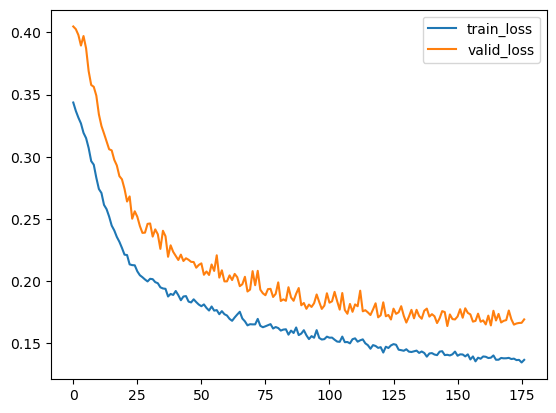

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_total, label = "train_loss")
plt.plot(valid_total, label = "valid_loss")
plt.legend(loc = "best")

plt.savefig('training_curve.png')
plt.show()

In [33]:
tmp = test_data.groupby(['deviceid'])['Beverage'].count()
counts = tmp.values

In [35]:
car_time = test_data.iloc[:, 0:2]
test_data = test_data.iloc[:, 2:]
test_data.head()

,CPC,Pa-chin-ko,ad,administrative,agrarian,alcohol,amenity=karaoke_box,animal_boarding,animal_breeding,animal_shelter,...,soap,surf,tea;米舖,vehicle_ramp,媒體,安全帽，雨衣，行車紀錄器,手作坊,洗衣店,觀光旅遊,農機行
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
test_dataset = myDataset(test_data.values, counts, segment_len)
test_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        num_workers = n_workers,
        pin_memory = True,
        collate_fn = collate_batch,
    )

In [53]:
len(test_loader)

49

In [37]:
infer_model = torch.load('/kaggle/working/best_model.pt')

In [38]:
infer_model

LstmAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(420, 16, batch_first=True)
    (rnn2): LSTM(16, 8, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(8, 8, batch_first=True)
    (rnn2): LSTM(8, 16, batch_first=True)
    (output_layer): Linear(in_features=16, out_features=420, bias=True)
  )
)

In [64]:
infer_model.eval()
result = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch = batch.float().to(device)
        prediction = model.encode(batch)
    
        result.extend(prediction.tolist())            

In [67]:
numbers = [str(i) for i in range(embedding_dim)]
df = pd.DataFrame(result, index = tmp.index, columns = numbers)
df.to_csv('result.csv')